# Getting and preparing the data



To demonstrate the post processing algorithm we use the "Adult Data Set" from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/adult). The task there is to predict whether a person makes more or less than $50k based on just a few attributes such as age, sex, race, education, occupation, etc.

To start, let's download the dataset:

In [8]:
import pandas as pd
import numpy as np

columns = ['age', 'workclass', 'fnlwgt', 'education_text', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

data = pd.read_csv('adult.data', names=columns)
data_test = pd.read_csv('adult.test', names=columns, skiprows=[0])

data.head()

,age,workclass,fnlwgt,education_text,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Since we need to encode categorical attributes properly, there are a few additional steps to take.

In [9]:
# one hot encoding
def transform_data(data):
    X = data[['age', 'education', 'capital_gain', 'capital_loss', 'hours_per_week']]
    X = X.join((data.sex == " Male") * 1)
    X = X.join(pd.get_dummies(data.workclass))
    del X[' ?']
    X = X.join(pd.get_dummies(data.occupation))
    del X[' ?']
    X = X.join(pd.get_dummies(data.relationship))
    X = X.join(pd.get_dummies(data.race))
    X = X.join(pd.get_dummies(data.native_country))
    y = ((data.income == ' >50K') | (data.income == ' >50K.')) * 1
    return X, y

full_X, full_y = transform_data(pd.concat([data, data_test], ignore_index=True))
X_train, y_train = full_X[:len(data)], full_y[:len(data)]
X_test, y_test = full_X[len(data):], full_y[len(data):]
X_test = X_test.set_index(pd.Index(list(range(len(X_test)))))
y_test.index = pd.Index(list(range(len(y_test))))
X_train.join(y_train).head()

,age,education,capital_gain,capital_loss,hours_per_week,sex,Federal-gov,Local-gov,Never-worked,Private,...,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,income
0,39,13,2174,0,40,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,13,0,0,13,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,9,0,0,40,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,53,7,0,0,40,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,28,13,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Create a fairness-unaware model

In [13]:
from sklearn.linear_model import LogisticRegression

fairness_unaware_model = LogisticRegression(solver='liblinear')
fairness_unaware_model.fit(X_train, y_train)

def show_proportions(X, y_pred, y=None, description=None):
    male_indices = X.index[X.sex == 1]
    female_indices = X.index[X.sex == 0]

    males_earning_more_than_50k = sum(y_pred[male_indices])
    females_earning_more_than_50k = sum(y_pred[female_indices])
    print("\n" + description)
    print("P[predicted income > 50k | male] = {}".format(males_earning_more_than_50k/len(male_indices)))
    print("P[predicted income > 50k | female] = {}".format(females_earning_more_than_50k/len(female_indices)))
    
    if y is not None:
        positive_male_indices = X.index[(X.sex == 1) & (y == 1)]
        negative_male_indices = X.index[(X.sex == 1) & (y == 0)]
        positive_female_indices = X.index[(X.sex == 0) & (y == 1)]
        negative_female_indices = X.index[(X.sex == 0) & (y == 0)]
        print("P[predicted income > 50k | male, income > 50k] = {}".format(sum(y_pred[positive_male_indices])/len(positive_male_indices)))
        print("P[predicted income > 50k | female, income > 50k] = {}".format(sum(y_pred[positive_female_indices])/len(positive_female_indices)))
        print("P[predicted income > 50k | male, income <= 50k] = {}".format(sum(y_pred[negative_male_indices])/len(negative_male_indices)))
        print("P[predicted income > 50k | female, income <= 50k] = {}".format(sum(y_pred[negative_female_indices])/len(negative_female_indices)))
    
show_proportions(X_train, y_train, description="original training data:")
show_proportions(X_train, fairness_unaware_model.predict(X_train), y_train, description="fairness-unaware prediction on training data:")
show_proportions(X_test, y_test, description="original test data:")
show_proportions(X_test, fairness_unaware_model.predict(X_test), y_test, description="fairness-unaware prediction on test data:")


original training data:
P[predicted income > 50k | male] = 0.3057365764111978
P[predicted income > 50k | female] = 0.10946058861758426

fairness-unaware prediction on training data:
P[predicted income > 50k | male] = 0.25672326755392383
P[predicted income > 50k | female] = 0.06963141769566428
P[predicted income > 50k | male, income > 50k] = 0.6161813269288502
P[predicted income > 50k | female, income > 50k] = 0.4851569126378287
P[predicted income > 50k | male, income <= 50k] = 0.0984267583289265
P[predicted income > 50k | female, income <= 50k] = 0.018557130942452045

original test data:
P[predicted income > 50k | male] = 0.2998158379373849
P[predicted income > 50k | female] = 0.10883600811658366

fairness-unaware prediction on test data:
P[predicted income > 50k | male] = 0.25202578268876613
P[predicted income > 50k | female] = 0.06696181516325402
P[predicted income > 50k | male, income > 50k] = 0.6102579852579852
P[predicted income > 50k | female, income > 50k] = 0.47627118644067795

We notice a stark contrast in the predictions, with males being a lot more likely to be predicted to earn more than $\$50k$, similar to the original training data. However, there's even a disparity between the subgroup of males and females that earn $\$50k$ with 61.6% of males predicted to earn more than $\$50k$, and only 48.5% of females. When considering only the samples labeled with $\leq\$50k$ males (9.8%) are more than five times as likely as females (1.9%) to be predicted to earn more than $\$50k$. The test data shows a similar disparity.

# Post-processing the model to get a fair model

The idea behind post-processing is to alter the output of the fairness-unaware model to achieve fairness. The post-processing algorithm requires three input arguments:
- the matrix of samples X
- the vector of predictions y from the fairness-unaware model 
- the vector of protected attribute values A

The goal is to make the output fair with respect to a disparity metric. Our post-processing algorithm uses one of
- Demographic Parity (DP): $P[h(X)=\hat{y} | A=a] = P[h(X)=\hat{y}] \qquad \forall a, \hat{y}$
- Equalized Odds (EO): $P[h(X)=\hat{y} | A=a, Y=y] = P[h(X)=\hat{y}|Y=y] \qquad \forall a, \hat{y}$

where $h(X)$ is the prediction based on the input $X$, $\hat{y}$ and $y$ are labels, and $a$ is a protected attribute value. In our example, we'd expect the post-processed model with DP to be balanced between sexes. EO does not make the same guarantees. Instead, it ensures that the parity between the subgroups of each sex with label 1 in the training set, and parity between the subgroups of each sex with label 0 in the training set. Applied to our scenario, this means that men and women with income over $\$50,000$ are equally likely to have a predicted income over $\$50,000$ (and therefore also equally likely to have a predicted income no higher than $\$50,000$). Similarly, there is parity between men and women with income under $\$50,000$, but we have no parity between the groups with different training labels. In mathematical terms:

$$
P[\text{predicted income > 50k} | \text{male, income > 50k}] = P[\text{predicted income > 50k} | \text{female, income > 50k}], \text{e.g. } 0.95\\
P[\text{predicted income > 50k} | \text{male, income <= 50k}] = P[\text{predicted income > 50k} | \text{female, income <= 50k}], \text{e.g. } 0.15
$$

but that also means that men (and women) of different subgroup based on training labels don't necessarily have parity:

$$
P[\text{predicted income > 50k} | \text{male, income > 50k}] = 0.95 \neq 0.15 = P[\text{predicted income > 50k} | \text{male, income <= 50k}]
$$

Assessing which disparity metric is indeed fair varies by application scenario.

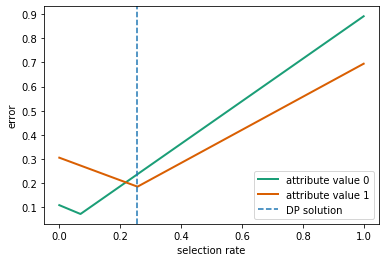


demographic parity with post-processed model on training data:
P[predicted income > 50k | male] = 0.25589720055071136
P[predicted income > 50k | female] = 0.25680066846160987
P[predicted income > 50k | male, income > 50k] = 0.6137796457520264
P[predicted income > 50k | female, income > 50k] = 0.5903307888040712
P[predicted income > 50k | male, income <= 50k] = 0.09829455314648335
P[predicted income > 50k | female, income <= 50k] = 0.2158048373644704

demographic parity with post-processed model on test data:
P[predicted income > 50k | male] = 0.2516574585635359
P[predicted income > 50k | female] = 0.2508762220992437
P[predicted income > 50k | male, income > 50k] = 0.609029484029484
P[predicted income > 50k | female, income > 50k] = 0.5661016949152542
P[predicted income > 50k | male, income <= 50k] = 0.09863229879011047
P[predicted income > 50k | female, income <= 50k] = 0.21237838956737737


In [14]:
from fairlearn.post_processing.roc_curve_based_post_processing import ROCCurveBasedPostProcessing
from fairlearn.metrics import DemographicParity
from copy import deepcopy

post_processed_model_DP = ROCCurveBasedPostProcessing(fairness_unaware_model=deepcopy(fairness_unaware_model), fairness_metric=DemographicParity(), plot=True, seed=0)

post_processed_model_DP.fit(X_train.values, y_train.values, protected_attribute=X_train.sex.values)

fairness_aware_predictions_DP_train = post_processed_model_DP.predict(X_train.values, protected_attribute=X_train.sex.values)
fairness_aware_predictions_DP_test = post_processed_model_DP.predict(X_test.values, protected_attribute=X_test.sex.values)

show_proportions(X_train, fairness_aware_predictions_DP_train, y_train, description="demographic parity with post-processed model on training data:")
show_proportions(X_test, fairness_aware_predictions_DP_test, y_test, description="demographic parity with post-processed model on test data:")

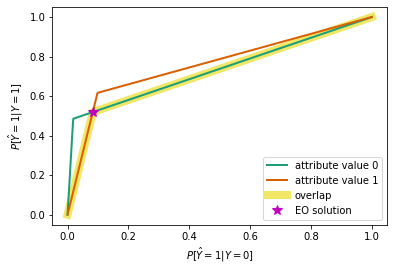


equalized odds with post-processed model on training data:
P[predicted income > 50k | male] = 0.216704910509408
P[predicted income > 50k | female] = 0.12840033423080494
P[predicted income > 50k | male, income > 50k] = 0.5199639747823477
P[predicted income > 50k | female, income > 50k] = 0.5250212044105174
P[predicted income > 50k | male, income <= 50k] = 0.08315705975674247
P[predicted income > 50k | female, income <= 50k] = 0.07964970809007506

equalized odds with post-processed model on test data:
P[predicted income > 50k | male] = 0.20957642725598527
P[predicted income > 50k | female] = 0.12783619258439402
P[predicted income > 50k | male, income > 50k] = 0.5070638820638821
P[predicted income > 50k | female, income > 50k] = 0.5033898305084745
P[predicted income > 50k | male, income <= 50k] = 0.08219358232509205
P[predicted income > 50k | female, income <= 50k] = 0.0819706064996895


In [15]:
from fairlearn.post_processing.roc_curve_based_post_processing import ROCCurveBasedPostProcessing
from fairlearn.metrics import EqualizedOdds
from copy import deepcopy

post_processed_model_EO = ROCCurveBasedPostProcessing(fairness_unaware_model=deepcopy(fairness_unaware_model), fairness_metric=EqualizedOdds(), plot=True, seed=0)

post_processed_model_EO.fit(X_train.values, y_train.values, protected_attribute=X_train.sex.values)

fairness_aware_predictions_EO_train = post_processed_model_EO.predict(X_train.values, protected_attribute=X_train.sex.values)
fairness_aware_predictions_EO_test = post_processed_model_EO.predict(X_test.values, protected_attribute=X_test.sex.values)

show_proportions(X_train, fairness_aware_predictions_EO_train, y_train, description="equalized odds with post-processed model on training data:")
show_proportions(X_test, fairness_aware_predictions_EO_test, y_test, description="equalized odds with post-processed model on test data:")